# Day 42 · 图像数据与显存

本节聚焦图像数据（MNIST 与 CIFAR-10）的形状特征、MLP 模型定义以及 batch_size 与显存的关系，目标是把概念清晰拆解并配合可运行的示例。

## 1. 图像数据基础
- 图像数据需要同时保留通道、宽和高，因此形状比结构化表格更复杂。
- 了解灰度图和彩色图的差异是后续处理（预处理、建模、显存估算）的前提。

### 1.1 灰度图像（MNIST）
下面对比图像与结构化数据的形状：

| 数据类型 | 形状示例 | 说明 |
|----------|---------|------|
| 表格数据 | (1000, 5) | 1000 个样本、5 个特征，顺序不体现空间关系 |
| MNIST 图像 | (1, 28, 28) | 1 个通道（灰度），28×28 像素保留空间位置信息 |

像素最初是 0~255 的 `uint8`，通过 `transforms.ToTensor()` 会被缩放到 [0,1] 并转成 `float32`，方便做梯度计算。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# 为了得到可复现的随机结果
torch.manual_seed(42)

# MNIST 的预处理：归一化 + 标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 下载/加载训练与测试集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

随机挑一张手写数字观察像素与标签，顺便复习反标准化操作。

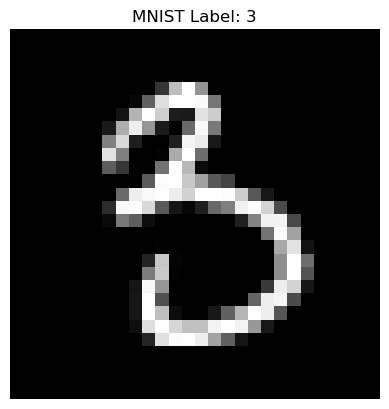

In [2]:
# 随机取一张图片并可视化
sample_idx = int(torch.rand(1).item() * len(train_dataset))
image, label = train_dataset[sample_idx]

def show_gray_tensor(img):
    """反标准化并展示灰度图。"""
    img = img * 0.3081 + 0.1307  # 还原为 0~1 范围
    np_img = img.numpy()
    plt.imshow(np_img[0], cmap='gray')
    plt.title(f'MNIST Label: {label}')
    plt.axis('off')
    plt.show()

show_gray_tensor(image)

使用 `Channels × Height × Width` 的格式是 PyTorch 的默认约定。下面确认一下单张图片的形状。

In [3]:
image.shape

torch.Size([1, 28, 28])

### 1.2 彩色图像（CIFAR-10）
- 彩色图像通常具有 3 个通道（RGB），张量形状为 `(3, H, W)`。
- 在可视化时，`matplotlib` 期望 `(H, W, C)`，需要 `permute` 调整顺序。
- 模型输入通常再额外加上一维 batch，形状 `(Batch, C, H, W)`。

100%|██████████| 170M/170M [00:30<00:00, 5.66MB/s] 


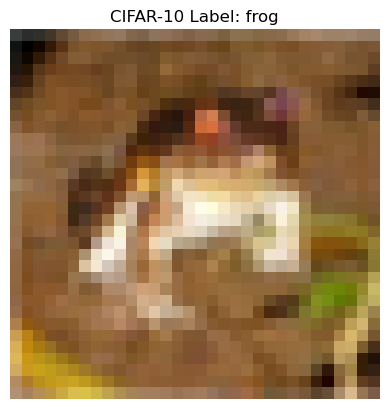

In [5]:
# 下载 Cifar10 并展示一张彩色图片
color_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=color_transform)
color_img, color_label = cifar_train[0]

# Cifar10 的标签名称
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.imshow((color_img.permute(1, 2, 0) * 0.5 + 0.5).numpy())  # 反标准化并调整维度顺序
plt.title(f'CIFAR-10 Label: {classes[color_label]}')
plt.axis('off')
plt.show()

## 2. 图像相关的神经网络
图像输入在送入全连接层前通常需要展平，通道维度也会体现在输入特征数上。这里先看两个基础 MLP，再讨论 batch_size 与模型的关系。

### 2.1 灰度图像 MLP（MNIST）
关键点：
1. `nn.Flatten()` 或 `view` 负责把 `[1, 28, 28]` 拉直成 784 维。
2. 输入层参数数量直接与像素数相关。
3. 在推理或训练中，`batch_size` 只会额外增加一个前缀维度 `[batch, 1, 28, 28]`。

In [6]:
class MnistMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  # 只展平成 784 维，不动 batch 维
        self.layer1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 10)  # 10 个数字类别

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mnist_model = MnistMLP().to(device)

**参数计算示例**（float32）：
- layer1：`784 × 128 = 100,352` 个权重 + `128` 个偏置 → 100,480 参数，约 402 KB。
- layer2：`128 × 10 = 1,280` 个权重 + `10` 个偏置 → 1,290 参数，约 5 KB。
- 总计 101,770 参数，梯度在反向传播时会复制一份，显存翻倍。

### 2.2 彩色图像 MLP（CIFAR-10）
彩色图片有 3 个通道，展平后特征数量直接变为 `3 × 32 × 32 = 3072`，因此参数规模更大。

In [7]:
class ColorMLP(nn.Module):
    def __init__(self, input_size=3 * 32 * 32, hidden_size=128, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

color_model = ColorMLP().to(device)

**参数量对比**
- 第一层：`3072 × 128 = 393,216` 权重 + 128 偏置 → 393,344 参数。
- 第二层与灰度模型相同：1,290 参数。
- 总量 394,634 参数，仅第一层就比灰度模型多约 4 倍显存。

### 2.3 batch_size 与模型结构
- 模型定义只需关注单个样本的形状 `(C, H, W)`。
- `torchsummary.summary(model, input_size=(1, 28, 28))` 也是如此，batch 维度无需传入。
- `DataLoader` 决定 batch_size，模型在 forward 中自动沿着 batch 维进行并行运算。

In [8]:
class BatchAgnosticMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # nn.Flatten()会将每个样本的图像展平为 784 维向量，但保留 batch 维度。
        self.layer1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)  # 输入：[batch_size, 1, 28, 28] → [batch_size, 784]
        x = self.layer1(x)   # [batch_size, 784] → [batch_size, 128]
        x = self.relu(x)
        x = self.layer2(x)   # [batch_size, 128] → [batch_size, 10]
        return x

batch_model = BatchAgnosticMLP()

| 组件 | 是否依赖 batch_size | 说明 |
|------|--------------------|------|
| 模型定义 | 否 | 只需传入单样本形状 |
| torchsummary / torchinfo | 否 | `input_size=(C,H,W)` 即可 |
| DataLoader | 是 | 在此设置 `batch_size=64` 等参数 |
| 训练循环 | 是 | `for data, target in loader:` 自动批处理 |

## 3. 显存占用与 batch_size 选择
当数据集太大无法一次放入显存时，需要合理选择 batch_size。
如果 batch_size 过小，算力利用不足；过大则容易 OOM。下面拆分显存的主要组成部分。

In [9]:
# 示例数据加载器，方便后续讨论 batch_size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### 3.1 模型参数与梯度
- MNIST MLP 共有 101,770 个 float32 参数，单份参数占用约 403 KB。
- 反向传播会为梯度再开辟一份同等大小的显存，训练时约 806 KB。
- 基本换算：`1 Byte = 8 bit`，`1 KB = 1024 Byte`，便于将参数量转成显存大小。

### 3.2 优化器状态
- SGD 默认不额外保存动量，显存占用 = 参数 + 梯度。
- Adam 需要同时保存一阶动量 `m` 与二阶动量 `v`，额外占用约 2 倍参数大小。
- 以 MNIST MLP 为例：Adam 需要额外 ~806 KB，总显存约 1.6 MB。

### 3.3 数据批量（batch_size）
- 单张 MNIST 张量大小：`1 × 28 × 28 × 4 Byte ≈ 3 KB`。
- `batch_size=64` → 数据约 192 KB；`batch_size=1024` → 数据约 3 MB。
- 数据越多，显存越高；需要兼顾显卡上限和训练稳定性。

### 3.4 中间激活
- 对两层 MLP 来说，中间特征约为 `batch_size × 128 × 4 Byte`。
- `batch_size=1024` 时约 512 KB，规模不大，但在深层网络或高分辨率输入时会快速增长。

### 3.5 batch_size 的显存估算示例（SGD）
| batch_size | 数据占用 | 中间激活 | 估算总占用* |
|------------|----------|----------|--------------|
| 64 | ~192 KB | ~32 KB | ~1 MB |
| 256 | ~768 KB | ~128 KB | ~1.7 MB |
| 1024 | ~3 MB | ~512 KB | ~4.5 MB |
| 4096 | ~12 MB | ~2 MB | ~15 MB |

*示例总量 = 参数 + 梯度 + 数据 + 激活，忽略优化器额外状态，仅用于估算量级。

### 3.6 实战建议
- `DataLoader` 默认 `batch_size=1`，并不会自动一次读取全部数据。
- 寻找合适 batch_size 的常见流程：从 16/32 起步 → 逐渐增大 → 监控 `nvidia-smi`，在 OOM 之前略微回退。
- 较大的 batch_size 可充分利用 GPU 并行能力，梯度更平滑；但在数据较少或显存受限时应灵活调整。